In [ ]:
# ==============================================================================
# EXERCISE 3
# ==============================================================================

In [ ]:
# import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# ==============================================================================
# 1. Basic RNN Cell Implementation
# ==============================================================================

class SimpleRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleRNNCell, self).__init__()
        # Store sizes for clarity and potential use later.
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Define learnable weights for the transformations.
        # nn.Parameter registers these tensors as model parameters, so they are tracked by optimizers.
        # weight_ih: Transforms the input 'x_t' to the hidden space.
        # Shape: (hidden_size, input_size)
        self.weight_ih = nn.Parameter(torch.randn(hidden_size, input_size))
        # weight_hh: Transforms the previous hidden state 'h_{t-1}' to the hidden space.
        # Shape: (hidden_size, hidden_size)
        self.weight_hh = nn.Parameter(torch.randn(hidden_size, hidden_size))
        # bias: Added after the linear transformations. Improves model flexibility.
        # Shape: (hidden_size)
        self.bias = nn.Parameter(torch.randn(hidden_size))

        # Initialize weights randomly (randn). Used torch.randn for simplicity—easier to implement in PyTorch.
        # Other initializations like Xavier or Kaiming could be used for potentially better convergence.
        # torch.randn(...) initializes weights with standard normal distribution. It's simple but can lead to exploding/vanishing gradients in deeper nets.
        # nn.init.xavier_uniform_ (Xavier/Glorot): better for tanh or sigmoid activations.
        # nn.init.kaiming_uniform_ (He): better for ReLU.
        # https://paperswithcode.com/method/xavier-initialization
        # https://paperswithcode.com/method/he-initialization
    def forward(self, input_tensor, hidden_state):
        # Use F.linear for matrix multiplication and bias addition.
        # It's equivalent to 'input @ weight.T + bias'.
        # Calculate the linear transformation of the input.
        input_transform = F.linear(input_tensor, self.weight_ih)
        # Calculate the linear transformation of the previous hidden state and add bias.
        hidden_transform = F.linear(hidden_state, self.weight_hh, self.bias)

        # Apply the hyperbolic tangent (tanh) activation function.
        # This introduces non-linearity and keeps the hidden state values
        # bounded between -1 and 1, helping to prevent exploding gradients.
        # Compute the next hidden state: h_t = tanh(W_ih * x_t + W_hh * h_{t-1} + b)
        h_next = torch.tanh(input_transform + hidden_transform)

        return h_next

# --- Annotations ---
# • The `SimpleRNNCell` class defines the computation for a single time step (t).
# • `__init__`: Sets up the necessary learnable parameters (weights `weight_ih`, `weight_hh`, and `bias`). These parameters will be adjusted during training.
# • `weight_ih`: Learns to map the input features (`input_size`) to the hidden state dimension (`hidden_size`).
# • `weight_hh`: Learns to map the previous hidden state (`hidden_size`) to the current hidden state dimension (`hidden_size`), capturing temporal dependencies.
# • `bias`: An additive term to shift the activation function's input, increasing model capacity.
# • `forward`: Implements the core RNN equation `h_t = activation(W_ih * x_t + W_hh * h_{t-1} + b)`.
# • `input_tensor` (`x_t`): The input vector at the current time step.
# • `hidden_state` (`h_{t-1}`): The memory/context from the previous time step.
# • `F.linear`: A functional way to apply a linear transformation (matrix multiplication + optional bias). Here, bias is added only in the hidden transformation for efficiency, effectively combining `b_ih` and `b_hh` into one `b`.
# • `torch.tanh`: The non-linear activation function. It squashes the weighted sum into the range [-1, 1].

# --- Potential Optimizations or Alternative Implementations ---
# • `nn.Linear`: Using `nn.Linear` layers instead of manual `nn.Parameter` and `F.linear` can make the code slightly cleaner and potentially benefit from internal optimizations within PyTorch. Two `nn.Linear` layers would be needed, one for input and one for hidden state. (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
# • Activation Function: ReLU or other activation functions could be used instead of tanh, although tanh is traditional for basic RNNs. ReLU might lead to faster training but could suffer from unbounded activations if not controlled. (https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
# • Initialization: Using more sophisticated weight initialization schemes (e.g., Xavier/Glorot or Kaiming/He initialization) instead of simple `randn` can lead to faster convergence and prevent vanishing/exploding gradients during the initial phases of training. (https://pytorch.org/docs/stable/nn.init.html)
# • Bias Splitting: The bias could be split into `bias_ih` and `bias_hh`. While mathematically equivalent when combined, separating them might offer slightly more flexibility if specific regularization techniques were applied differently to input vs. recurrent connections. (https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
# • Matrix Multiplication Optimization: Matrix multiplications could be batched across time steps or combined using fused operations for better GPU utilization and throughput. (https://pytorch.org/blog/optimizing-cuda-rnn-with-torchscript/)
# • Sequence Handling: This implementation processes a single time step. For sequences, it must be iterated over manually, or wrapped in a custom RNN layer/class. Alternatively, PyTorch’s built-in `nn.RNN` module can be used. (https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

# --- Connection to Theoretical Concepts ---
# • Recurrence Relation: This code directly implements the fundamental RNN recurrence relation: `h_t = f(W * [h_{t-1}, x_t] + b)`, where `f` is the activation function (tanh here). The hidden state `h_t` is computed based on the current input `x_t` and the previous hidden state `h_{t-1}`.
# • Hidden State as Memory: The `hidden_state` tensor acts as the RNN's memory, carrying information from past time steps to influence the processing of future time steps. The quality of this memory is limited in simple RNNs (leading to vanishing gradients).
# • Parameter Sharing: The same weight matrices (`weight_ih`, `weight_hh`) and bias (`bias`) are used across all time steps for processing the sequence. This makes the model parameter-efficient and allows it to generalize patterns across different sequence positions.
# • Non-linearity: The `tanh` activation is crucial. Without it, the RNN would just be a series of linear transformations, collapsing into a single linear transformation, unable to model complex temporal dependencies.

# Example Usage (Conceptual - requires iteration over a sequence)
# batch_size = 5
# input_size = 10
# hidden_size = 20
# seq_len = 15
#
# rnn_cell = SimpleRNNCell(input_size, hidden_size)
# input_sequence = torch.randn(seq_len, batch_size, input_size) # Example input sequence
# h_t = torch.zeros(batch_size, hidden_size) # Initial hidden state
#
# outputs = []
# for t in range(seq_len):
#     x_t = input_sequence[t] # Get input for time step t
#     h_t = rnn_cell(x_t, h_t) # Compute next hidden state
#     outputs.append(h_t)
#
# # 'outputs' now contains the hidden state for each time step.
# # final_output = torch.stack(outputs, dim=0) # Shape: (seq_len, batch_size, hidden_size)

print("Implemented Basic RNN Cell.")

# References

# https://medium.com/data-science/recurrent-neural-networks-rnns-3f06d7653a85
# https://d2l.ai/chapter_recurrent-neural-networks/index.html

# ==============================================================================
# 2. LSTM Cell Implementation
# ==============================================================================

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Combine weights for all four gates (input, forget, cell, output) into single weight matrices for efficiency. This allows for a single matrix
        # multiplication for both input-to-hidden and hidden-to-hidden transformations, which is often optimized in deep learning libraries.
        # The total size is 4 * hidden_size because each of the four gates needs a transformation resulting in a vector of size hidden_size.

        # Weights for input-to-gate transformations (W_i, W_f, W_g, W_o combined)
        self.weight_ih = nn.Parameter(torch.randn(4 * hidden_size, input_size))
        # Weights for hidden-to-gate transformations (U_i, U_f, U_g, U_o combined)
        self.weight_hh = nn.Parameter(torch.randn(4 * hidden_size, hidden_size))
        # Biases for the gates (b_i, b_f, b_g, b_o combined)
        # Use separate biases for the input-to-gate and hidden-to-gate transformations, although they are often
        # combined into a single bias term per gate in practice (like PyTorch's default).
        self.bias_ih = nn.Parameter(torch.randn(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(4 * hidden_size))

    def forward(self, input_tensor, state):
        # Unpack the previous hidden state and cell state
        h_prev, c_prev = state

        # Compute the linear transformations for all gates at once.
        # Calculate W * x_t + b_ih
        input_gates = F.linear(input_tensor, self.weight_ih, self.bias_ih)
        # Calculate U * h_{t-1} + b_hh
        hidden_gates = F.linear(h_prev, self.weight_hh, self.bias_hh)
        # Combine the transformations
        gates = input_gates + hidden_gates

        # Split the combined gate tensor into four individual gate tensors.
        # chunk(4, dim=1) splits the tensor along dimension 1 (the feature dimension) into 4 equal parts.
        # i: input gate, f: forget gate, g: cell gate (candidate values), o: output gate
        i, f, g, o = gates.chunk(4, dim=1)

        # Apply appropriate activation functions to each gate.
        # Sigmoid for gates (i, f, o) to scale values between 0 and 1, controlling flow.
        # Tanh for the cell candidate gate (g) to scale values between -1 and 1.
        i = torch.sigmoid(i) # Input gate: Controls how much new info (g) is added.
        f = torch.sigmoid(f) # Forget gate: Controls how much old info (c_prev) is kept.
        g = torch.tanh(g)    # Cell gate: Computes candidate values for the cell state.
        o = torch.sigmoid(o) # Output gate: Controls how much of the cell state is exposed.

        # Calculate the next cell state (c_t)
        # c_t = f_t * c_{t-1} + i_t * g_t
        # Element-wise multiplication (*) is used.
        c_next = f * c_prev + i * g

        # Calculate the next hidden state (h_t)
        # h_t = o_t * tanh(c_t)
        # Apply tanh to the new cell state before multiplying by the
        # output gate. This keeps the hidden state values bounded.
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

# --- Annotations ---
# • The `LSTMCell` class defines the computation for one time step, similar to the RNN cell, but with more complex internal logic.
# • `__init__`: Initializes parameters. Crucially, the weight and bias parameters are 4 times the `hidden_size` because they contain parameters for all four gates (input `i`, forget `f`, cell candidate `g`, output `o`) concatenated together.
# • `weight_ih`: Contains `W_ii, W_if, W_ig, W_io` concatenated.
# • `weight_hh`: Contains `W_hi, W_hf, W_hg, W_ho` concatenated.
# • `bias_ih`, `bias_hh`: Contain corresponding concatenated biases `b_ii, b_if, b_ig, b_io` and `b_hi, b_hf, b_hg, b_ho`.
# • `forward`: Takes the current input `input_tensor` (`x_t`) and a tuple `state` containing the previous hidden state (`h_{t-1}`) and previous cell state (`c_{t-1}`).
# • Gate Computations: First, linear transformations are applied to `x_t` and `h_{t-1}` using the combined weights/biases. The result `gates` contains the pre-activation values for all four gates.
# • `gates.chunk(4, dim=1)`: Splits the result into four tensors, one for each gate (`i`, `f`, `g`, `o`).
# • Activation Functions: Sigmoid (`torch.sigmoid`) is applied to `i`, `f`, `o` to make them act like gates (values between 0 and 1, controlling information flow). Tanh (`torch.tanh`) is applied to `g` to create candidate values for the cell state (values between -1 and 1).
# • Cell State Update (`c_next`): This is the core of the LSTM's memory. `f * c_prev` scales the old cell state (deciding what to forget), and `i * g` scales the new candidate values (deciding what new information to add). `c_t = f_t ⊙ c_{t-1} + i_t ⊙ g_t`.
# • Hidden State Update (`h_next`): The output gate `o` filters the (tanh-activated) new cell state `c_next` to produce the hidden state `h_t` that is passed to the next time step and potentially used as the output for the current step. `h_t = o_t ⊙ tanh(c_t)`.
# • Return Value: Returns both the new hidden state (`h_next`) and the new cell state (`c_next`).

# --- Potential Optimizations or Alternative Implementations ---
# • `nn.Linear`: Similar to the RNN, using `nn.Linear(input_size + hidden_size, 4 * hidden_size)` on a concatenated input `[input_tensor, h_prev]` could replace the manual `F.linear` calls and potentially be optimized by PyTorch. (https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)
# • Peephole Connections: An optional modification where the gate calculations also depend directly on the cell state (`c_{t-1}` or `c_t`). This adds extra parameters but can sometimes improve performance on specific tasks. E.g., `f = torch.sigmoid(..., W_fc @ c_prev)`. (https://ieeexplore.ieee.org/document/861302)
# • Initialization: Careful initialization (e.g., setting forget gate bias initially high, around 1.0) is often recommended to encourage the LSTM to enhance its performance across various tasks.(https://proceedings.mlr.press/v37/jozefowicz15.pdf)
# • Layer Normalization: Applying Layer Normalization to the gate activations or cell state can sometimes stabilize training and improve performance, especially in deeper LSTMs. (https://arxiv.org/abs/1607.06450)

# --- Connection to Theoretical Concepts ---
# • Gating Mechanisms: The core innovation of LSTMs. The input (`i`), forget (`f`), and output (`o`) gates are learnable functions that dynamically control the flow of information, addressing the vanishing/exploding gradient problem.
# • Cell State (`c`): Acts as the main information highway, carrying information potentially over long durations. Its updates are additive (controlled by `i` and `f`), making it less prone to vanishing gradients compared to the multiplicative updates in simple RNNs.
# • Forget Gate (`f`): Allows the LSTM to explicitly discard irrelevant information from the cell state (`f_t ⊙ c_{t-1}`).
# • Input Gate (`i`): Allows the LSTM to explicitly control which new information (from the candidate `g_t`) is added to the cell state (`i_t ⊙ g_t`).
# • Output Gate (`o`): Controls which parts of the cell state are filtered and exposed in the hidden state (`h_t`), which is used for predictions or passed to the next layer/time step.
# • Mitigation of Vanishing Gradients: The additive nature of the cell state update and the gating mechanisms allow gradients to flow back through time more effectively than in simple RNNs.

# Example Usage (Conceptual - requires iteration over a sequence)
# batch_size = 5
# input_size = 10
# hidden_size = 20
# seq_len = 15
#
# lstm_cell = LSTMCell(input_size, hidden_size)
# input_sequence = torch.randn(seq_len, batch_size, input_size)
# h_t = torch.zeros(batch_size, hidden_size) # Initial hidden state
# c_t = torch.zeros(batch_size, hidden_size) # Initial cell state
#
# outputs = []
# for t in range(seq_len):
#     x_t = input_sequence[t]
#     h_t, c_t = lstm_cell(x_t, (h_t, c_t)) # Note: state is now a tuple (h, c)
#     outputs.append(h_t)
#
# # final_output = torch.stack(outputs, dim=0)

print("Implemented LSTM Cell.")

# References

# https://d2l.ai/chapter_recurrent-modern/lstm.html
# https://medium.com/@samina.amin/understanding-lstms-lstm-implementation-from-scratch-18965a150eca


# ==============================================================================
# 3. Self-Attention Mechanism Implementation (Scaled Dot-Product Attention)
# ==============================================================================

class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_dim): # Usually d_k = d_v = hidden_dim / num_heads
        super(ScaledDotProductAttention, self).__init__()
        # Store the scaling factor directly. The square root of the
        # key dimension (d_k) is used to prevent the dot products from growing too large,
        # which could push the softmax function into regions with very small gradients.
        self.scale_factor = math.sqrt(hidden_dim)
        # Use dropout for regularization within the attention mechanism.
        # Applying dropout to the attention weights before multiplying with V helps prevent overfitting to specific attention patterns.
        # ( Dropout probability could be a parameter, default is often 0.1 )
        self.dropout = nn.Dropout(0.1)
        # Softmax is applied along the last dimension (key dimension) to get attention weights that sum to 1 for each query.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, query, key, value, mask=None):
        # 1. Compute dot products between Query and Key: Q @ K.T
        # Transpose the last two dimensions of the key tensor.
        # Result shape: (batch_size, ..., seq_len_q, seq_len_k)
        # Use torch.matmul for batch matrix multiplication.
        attention_scores = torch.matmul(query, key.transpose(-2, -1))

        # 2. Scale the scores
        # Divide by the square root of the key dimension (d_k).
        scaled_attention_scores = attention_scores / self.scale_factor

        # 3. Apply mask
        if mask is not None:
            # Fill masked positions with a very small number (-inf).
            # This ensures that after softmax, these positions will have near-zero probability.
            # The mask tensor provides 0s where it is wanted to mask, so it is directly used.
            # with fill_ where the condition (mask == 0) is true.
            # Make sure mask has compatible dimensions (broadcastable).
            # Example mask shapes: (batch, 1, 1, seq_len_k) for padding mask or
            # (batch, 1, seq_len_q, seq_len_k) for combined/look-ahead mask.
            scaled_attention_scores = scaled_attention_scores.masked_fill(mask == 0, float('-inf'))

        # 4. Apply softmax to get attention weights
        # Softmax is applied on the last dimension (seq_len_k), so weights sum to 1 for each query.
        # Shape: (batch_size, ..., seq_len_q, seq_len_k)
        attention_weights = self.softmax(scaled_attention_scores)

        # Apply dropout to attention weights for regularization.
        attention_weights = self.dropout(attention_weights)

        # 5. Compute the weighted sum of Values
        # Multiply attention weights by the Value tensor.
        # Result shape: (batch_size, ..., seq_len_q, value_dim)
        output = torch.matmul(attention_weights, value)

        return output, attention_weights

# --- Annotations ---
# • The `ScaledDotProductAttention` class implements the core attention calculation.
# • `__init__`: Stores the scaling factor (`sqrt(d_k)`) and initializes dropout and softmax layers.
# • `scale_factor`: Crucial for stable training, prevents dot products from becoming too large, especially with high `hidden_dim`.
# • `forward`: Takes `query`, `key`, `value` tensors, and an optional `mask`.
# • `torch.matmul(query, key.transpose(-2, -1))`: Computes the raw attention scores by measuring the similarity (dot product) between each query vector and all key vectors.
# • Scaling: Divides the raw scores by `scale_factor`.
# • Masking: If a `mask` is provided (e.g., for padding or future tokens in decoders), it sets the scores at masked positions to a very large negative number (`float('-inf')`). This makes their probability effectively zero after softmax.
# • `self.softmax(dim=-1)`: Converts the scaled (and potentially masked) scores into probability distributions (attention weights) across the key/value sequence for each query. The weights sum to 1 along the key sequence length dimension (`seq_len_k`).
# • Dropout: Applied to the `attention_weights` to prevent the model from relying too heavily on a few specific input positions.
# • `torch.matmul(attention_weights, value)`: Computes the final output by taking a weighted sum of the `value` vectors, where the weights are the computed `attention_weights`. Each output vector is a blend of value vectors, weighted by their relevance to the corresponding query.
# • Return Value: Returns the attention output (context vector) and the attention weights (useful for analysis/visualization).

# --- Potential Optimizations or Alternative Implementations ---
# • Fused Kernels: Libraries like xformers or PyTorch 2.0+ provide fused attention implementations (e.g., `torch.nn.functional.scaled_dot_product_attention`) that combine scaling, masking, softmax, and dropout into a single, highly optimized GPU kernel. This is significantly faster and uses less memory than the manual steps shown here. (https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html)
# • Different Attention Types: This is scaled dot-product attention. Alternatives exist:
#     - Additive Attention (Bahdanau): Uses a feed-forward network to compute alignment scores. Can sometimes work better for lower dimensions but is often slower. `score(q, k) = v_a^T * tanh(W_q*q + W_k*k)` (https://d2l.ai/chapter_attention-mechanisms-and-transformers/bahdanau-attention.html)
#     - Cosine Similarity: Use cosine similarity instead of dot product. (https://arxiv.org/pdf/1702.05870)
# • Multi-Head Attention: This implementation is single-head. Multi-head attention (covered later) projects Q, K, V into multiple subspaces ("heads"), computes attention independently in each head, and concatenates the results. This allows the model to attend to information from different representation subspaces simultaneously. (https://d2l.ai/chapter_attention-mechanisms-and-transformers/multihead-attention.html)

# --- Connection to Theoretical Concepts ---
# • Attention Mechanism: Directly implements the concept of attention, allowing the model to focus on relevant parts of the input sequence (represented by values) based on a query and keys.
# • Query, Key, Value Abstraction: Represents information processing as a database retrieval analogy. The `query` asks a question, `keys` provide searchable identifiers for information, and `values` contain the actual information content. Attention finds which keys best match the query and retrieves a weighted combination of the corresponding values.
# • Softmax for Weighting: Softmax converts similarity scores into a probability distribution, providing normalized weights for combining the value vectors.
# • Scaling Factor: Addresses the issue that dot products grow in magnitude with dimensionality. Scaling ensures the variance of the dot products remains constant regardless of `d_k`, keeping softmax inputs in a reasonable range.
# • Self-Attention: When Q, K, and V are derived from the same input sequence (often through linear projections), it's called self-attention. This allows different positions in the sequence to interact and exchange information based on content similarity.

# Example Usage (Conceptual)
# batch_size = 4
# seq_len = 10
# hidden_dim = 64 # d_k, d_v usually this size
# embed_dim = 512 # Dimension of input embeddings
#
# # In a real scenario, Q, K, V are often linear projections of the input
# input_embeddings = torch.randn(batch_size, seq_len, embed_dim)
# W_q = nn.Linear(embed_dim, hidden_dim, bias=False)
# W_k = nn.Linear(embed_dim, hidden_dim, bias=False)
# W_v = nn.Linear(embed_dim, hidden_dim, bias=False)
#
# Q = W_q(input_embeddings) # Shape: (batch, seq_len, hidden_dim)
# K = W_k(input_embeddings) # Shape: (batch, seq_len, hidden_dim)
# V = W_v(input_embeddings) # Shape: (batch, seq_len, hidden_dim)
#
# attention_layer = ScaledDotProductAttention(hidden_dim=hidden_dim)
# # Optional mask (e.g., ignore padding tokens at index > 7)
# mask = torch.ones(batch_size, 1, seq_len, seq_len) # (Batch, Head, Seq_Q, Seq_K)
# mask[:, :, :, 8:] = 0 # Mask out last 2 positions
#
# attention_output, attention_weights = attention_layer(Q, K, V, mask=mask)
# print(attention_output.shape) # Should be (batch_size, seq_len, hidden_dim)
# print(attention_weights.shape) # Should be (batch_size, seq_len, seq_len)

print("Implemented Scaled Dot-Product Attention (Self-Attention basis).")

# References

# https://classic.d2l.ai/chapter_attention-mechanisms/self-attention-and-positional-encoding.html
# https://classic.d2l.ai/chapter_attention-mechanisms/attention-scoring-functions.html#equation-eq-softmax-qk-v
# https://medium.com/@vmirly/tutorial-on-scaled-dot-product-attention-with-pytorch-implementation-from-scratch-66ed898bf817

# ==============================================================================
# 4. Sequence-to-Sequence (Seq2Seq) Model with Attention
# ==============================================================================

class EncoderLSTM(nn.Module):
    def __init__(self, input_vocab_size, embed_dim, hidden_dim, num_layers=1, dropout=0.1):
        super(EncoderLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Embedding layer to convert input token indices into dense vectors.
        self.embedding = nn.Embedding(input_vocab_size, embed_dim)
        # Use PyTorch's nn.LSTM layer. It processes the entire sequence.
        # `batch_first=True` makes input/output tensors shape (batch, seq, feature).
        # Dropout is applied between LSTM layers if num_layers > 1.
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0) # NOTE: Dropout is ignored if num_layers=1, so it is disabled in that case.
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seq):
        # 1. Embed the input sequence
        # Shape: (batch_size, seq_len) -> (batch_size, seq_len, embed_dim)
        embedded = self.dropout(self.embedding(input_seq))

        # 2. Pass embedded sequence through LSTM
        # hidden_state tuple contains (final hidden state, final cell state)
        # Shape of h_n, c_n: (num_layers * num_directions, batch_size, hidden_size)
        # Shape of outputs: (batch_size, seq_len, num_directions * hidden_size)
        encoder_outputs, hidden_state = self.lstm(embedded) # Not provide initial h/c, defaults to zeros.

        # The encoder_outputs contain the hidden state for every time step.
        # The hidden_state tuple contains the final hidden and cell states.
        return encoder_outputs, hidden_state

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # No learnable parameters needed for simple dot-product attention.
        # Could use ScaledDotProductAttention or Bahdanau (additive) attention here too.
        self.softmax = nn.Softmax(dim=-1)
        # Store hidden_dim if scaling or other methods are used later.
        self.hidden_dim = hidden_dim
        self.scale = 1 / math.sqrt(hidden_dim)  # For scaled dot-product attention


    def forward(self, decoder_hidden, encoder_outputs):
        # Calculate alignment scores (dot product)
        # decoder_hidden shape: (batch, hidden)
        # encoder_outputs shape: (batch, seq_len_enc, hidden)
        # Want scores shape: (batch, seq_len_enc)
        # Need to match dimensions for batch matmul:
        # Query: (batch, 1, hidden)
        # Keys:  (batch, seq_len_enc, hidden) -> transpose -> (batch, hidden, seq_len_enc)
        # Result: (batch, 1, seq_len_enc) -> squeeze -> (batch, seq_len_enc)

        # Add a dimension to decoder_hidden for matmul
        query = decoder_hidden.unsqueeze(1) # Shape: (batch_size, 1, hidden_dim)

        # Calculate scores
        scores = torch.bmm(query, encoder_outputs.transpose(1, 2)).squeeze(1) * self.scale # Shape: (batch_size, 1, seq_len_enc)
        scores = scores.squeeze(1) # Shape: (batch_size, seq_len_enc)

        # Apply softmax to get weights
        attention_weights = self.softmax(scores) # Shape: (batch_size, seq_len_enc)

        # Calculate context vector (weighted sum of encoder outputs)
        # weights shape: (batch, 1, seq_len_enc) for bmm
        # values shape: (batch, seq_len_enc, hidden)
        # result shape: (batch, 1, hidden) -> squeeze -> (batch, hidden)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs) # Shape: (batch_size, 1, hidden_dim)
        context_vector = context_vector.squeeze(1) # Shape: (batch_size, hidden_dim)

        return context_vector, attention_weights

class DecoderLSTMWithAttention(nn.Module):
    def __init__(self, output_vocab_size, embed_dim, hidden_dim, num_layers=1, dropout=0.1):
        super(DecoderLSTMWithAttention, self).__init__()
        self.output_vocab_size = output_vocab_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_vocab_size, embed_dim)
        # Attention layer instance.
        self.attention = Attention(hidden_dim)
        # LSTM Cell to process one step at a time.
        # The input to the LSTM cell will be the concatenation of the embedded
        # previous output token and the context vector from attention.
        self.lstm_cell = nn.LSTMCell(embed_dim + hidden_dim, hidden_dim)
        # Output linear layer to map the combined output to vocab scores.
        # Input size is hidden_dim (from LSTM) + hidden_dim (from context) + embed_dim
        # Combine hidden state and context vector
        self.fc_out = nn.Linear(hidden_dim + hidden_dim, output_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, decoder_input, hidden_state, encoder_outputs):
        # 1. Embed the input token
        # Shape: (batch_size) -> (batch_size, embed_dim)
        embedded = self.dropout(self.embedding(decoder_input))

        # 2. Calculate attention weights and context vector
        # Use the previous hidden state (h_prev) as the query.
        # hidden_state[0] is h, hidden_state[1] is c.
        h_prev = hidden_state[0]
        context_vector, attention_weights = self.attention(h_prev, encoder_outputs)
        # context_vector shape: (batch_size, hidden_dim)
        # attention_weights shape: (batch_size, seq_len_enc)

        # 3. Combine embedded input and context vector
        # This combined vector will be the input to the LSTM cell.
        # Shape: (batch_size, embed_dim + hidden_dim)
        lstm_input = torch.cat((embedded, context_vector), dim=1)

        # 4. Pass through LSTM Cell
        # hidden_state is the tuple (h_prev, c_prev)
        hidden_state = self.lstm_cell(lstm_input, hidden_state)
        # hidden_state is now the tuple (h_next, c_next)

        # 5. Compute output prediction
        # Combine the new hidden state and the context vector before passing to the final fully connected layer.
        # This gives the output layer access to both the current decoder state and the relevant encoder context.
        h_next = hidden_state[0]
        output_combined = torch.cat((h_next, context_vector), dim=1)
        # Shape: (batch_size, hidden_dim + hidden_dim)

        prediction = self.fc_out(output_combined)
        # Shape: (batch_size, output_vocab_size)

        return prediction, hidden_state, attention_weights

# --- Overall Seq2Seq Model ---

class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device # Necessary for creating initial input tensor

        # Ensure hidden dimensions match
        assert encoder.hidden_dim == decoder.hidden_dim, "Hidden dimensions of encoder and decoder must be equal!"
        # Assume num_layers=1 for simplicity in passing state
        assert encoder.num_layers == 1, "Encoder num_layers > 1 not handled simply in this basic decoder setup."
        # If num_layers > 1, need to handle selecting the correct layer's state
        # If using multi-layer LSTM, need to pass only final layer's hidden state or merge states.

    def forward(self, input_seq, target_seq, teacher_forcing_ratio=0.5):
        batch_size = target_seq.shape[0]
        trg_len = target_seq.shape[1]
        trg_vocab_size = self.decoder.output_vocab_size

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # 1. Pass input sequence through encoder
        encoder_outputs, hidden_state = self.encoder(input_seq)
        # hidden_state is (h, c), each shape (num_layers=1, batch, hidden)
        # Need (batch, hidden) for the decoder cell, so squeeze num_layers dim
        decoder_hidden = (hidden_state[0].squeeze(0), hidden_state[1].squeeze(0))

        # 2. Prepare initial decoder input (<sos> token)
        # Typically, the first input to the decoder is the start-of-sequence token.
        # Assuming <sos> token index is 0 for simplicity.
        decoder_input = target_seq[:, 0] # Use first token of target for <sos> like prompt
        # Or create explicitly: torch.zeros(batch_size, dtype=torch.long).to(self.device)
        # Assume <sos> token is at position 0 in the target sequence. Adjust if using fixed token ID.

        # 3. Decoding loop
        for t in range(trg_len):
            # Run one step of the decoder
            prediction, decoder_hidden, _ = self.decoder(decoder_input,
                                                         decoder_hidden,
                                                         encoder_outputs)

            # Store the prediction
            outputs[:, t, :] = prediction # Shape (batch, vocab_size)

            # Decide whether to use teacher forcing
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio

            # Get the highest predicted token
            top1 = prediction.argmax(1) # Shape: (batch_size)

            # If teacher forcing, use actual next target token; else use prediction
            # decoder_input = target_seq[:, t] if teacher_force and t < trg_len -1 else top1 # Commented out redundant line

            # Ensure input is not out of bounds if using target_seq
            if t < trg_len -1: # Check index before accessing next target
                decoder_input = target_seq[:, t+1] if teacher_force else top1
                # Use teacher forcing or model's own prediction. Avoid index out of bounds by checking t < trg_len - 1.
                # Use teacher forcing if available, otherwise use model prediction. Prevent out-of-bounds access at last time step.
            else: # Last step, doesn't matter much what input is for next iteration
                decoder_input = top1

        return outputs # The outputs are raw logits. Use nn.CrossEntropyLoss (which applies softmax internally).

# --- Annotations ---
# • Architecture: Consists of an `EncoderLSTM`, a `DecoderLSTMWithAttention`, and an `Attention` module.
# • `EncoderLSTM`: Takes input sequence indices, embeds them, and processes them with an `nn.LSTM`. It returns all hidden states (`encoder_outputs`) and the final hidden and cell states.
# • `Attention`: Computes attention weights. Here, a simple dot-product attention is used. It takes the current decoder hidden state (`decoder_hidden`) as the query and the `encoder_outputs` as keys and values. It returns a `context_vector` (weighted sum of encoder outputs) and `attention_weights`.
# • `DecoderLSTMWithAttention`: Generates the output sequence one token at a time.
#     - Takes the previously generated token (`decoder_input`), the previous decoder hidden/cell state (`hidden_state`), and all `encoder_outputs`.
#     - Embeds the `decoder_input`.
#     - Uses the `attention` module with the previous hidden state `h_prev` to compute the `context_vector`.
#     - Concatenates the `embedded` input and the `context_vector`. This combined vector is fed into the `nn.LSTMCell` along with the previous `hidden_state`.
#     - The `nn.LSTMCell` produces the new hidden/cell state (`h_next`, `c_next`).
#     - Concatenates the `h_next` and the `context_vector` to form the input for the final linear layer (`fc_out`).
#     - `fc_out` projects this combined vector to the size of the output vocabulary, producing prediction scores.
# • `Seq2SeqAttention`: The main class orchestrating the process.
#     - Initializes encoder and decoder.
#     - `forward`: Takes source and target sequences.
#     - Encodes the `input_seq` to get `encoder_outputs` and the initial `decoder_hidden` state (the encoder's final state).
#     - Initializes the first `decoder_input` (e.g., <sos> token).
#     - Iterates `trg_len` times:
#         - Calls the `decoder`'s forward method for one step.
#         - Stores the output prediction.
#         - Implements Teacher Forcing: With probability `teacher_forcing_ratio`, the next `decoder_input` is the *actual* next token from `target_seq`. Otherwise, it's the token with the highest score from the current `prediction` (greedy decoding).
#     - Returns all predictions for the sequence.

# --- Connection to Theoretical Concepts ---
# • Sequence-to-Sequence Learning: The Seq2Seq architecture models a conditional sequence generation problem:
#     Given an input sequence X = (x₁, x₂, ..., xₙ), the model learns to generate an output sequence Y = (y₁, y₂, ..., yₘ).
#     This is particularly useful in tasks like machine translation, summarization, and question answering.
#
# • Encoder-Decoder Framework:
#     - The encoder compresses the input sequence into a fixed-dimensional context vector (final hidden state).
#     - The decoder unfolds the output sequence conditioned on this context.
#     - However, relying solely on the final encoder state limits performance on long sequences (information bottleneck).
#
# • Attention Mechanism:
#     - Introduced by Bahdanau et al. (2015), attention allows the decoder to dynamically focus on different parts of the input sequence during each decoding step.
#     - https://arxiv.org/abs/1409.0473
#     - This removes the fixed-length bottleneck and improves gradient flow during training.
#     - The attention module acts as a soft alignment function, learning where to "look" in the input when generating each token.
#
# • Dot-Product Attention:
#     - A simple and efficient way to compute similarity between the decoder's current hidden state (query) and each encoder output (keys).
#     - The similarity scores are normalized using softmax and used to compute a weighted sum (context vector) of encoder outputs (values).
#
# • Context Vector:
#     - Represents a weighted summary of the input sequence tailored to the current decoding step.
#     - It acts as dynamic memory that gives the decoder access to the full input sequence rather than a single summary.
#
# • Teacher Forcing:
#     - A technique used during training where the ground truth token is fed as the next input to the decoder, rather than the model’s own prediction.
#     - Helps speed up convergence and stabilizes training, especially in early stages.
#     - A stochastic version is used here, controlled by `teacher_forcing_ratio`.
#
# • Autoregressive Decoding:
#     - The decoder generates one token at a time, and each prediction conditions on previous tokens.
#     - This requires looping over the target sequence length during training/inference.
#
# • Attention Weights (Alignment Scores):
#     - These can be visualized to interpret which parts of the source sentence the model is attending to for each generated word.
#     - Useful for explainability and debugging.
#
# • Model Modularity:
#     - The model separates encoder, decoder, and attention, allowing flexible experimentation (e.g., replacing dot-product with additive attention, or encoder LSTM with Transformer).
#
# • RNN Limitations & Transition to Transformers:
#     - Seq2Seq models with attention address many limitations of vanilla RNNs but still suffer from slow inference and difficulty modeling long-range dependencies.
#     - These limitations led to the development of the Transformer architecture, which replaces recurrence with full attention mechanisms.


# --- Potential Optimizations or Alternative Implementations ---
# • Attention Mechanism: Replace simple dot-product attention with Scaled Dot-Product or Additive (Bahdanau) attention (from Part 3, previous part). This often involves adding linear layers to project decoder hidden state and encoder outputs before calculating scores.
# • Bidirectional Encoder: Use a bidirectional LSTM in the encoder (`bidirectional=True`). The `encoder_outputs` will have dimension `2 * hidden_dim`. The decoder's initial state needs to be adapted (e.g., by combining forward and backward final states, perhaps with a linear layer). (https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
# • Multi-Layer RNNs: Use `num_layers > 1` in both encoder and decoder for deeper processing. Handling the hidden states between encoder and decoder requires care (usually only the final layer's state initializes the decoder, or states are combined).
# • Decoder Cell: Custom `LSTMCell` could be used instead of `nn.LSTMCell`.
# • Beam Search Decoding: For inference (not training), replace greedy decoding (taking `argmax`) with beam search to find potentially better output sequences by keeping track of multiple candidate sequences. (https://www.width.ai/post/what-is-beam-search#:~:text=Beam%20Search:%20Using%20Conditional%20Probability&text=The%20beam%20search%20algorithm%20selects,to%20use%20beam%20search%20effectively.)
# • Input Feeding: A common technique where the previous attention context vector is also fed as input to the next time step's decoder LSTM cell, in addition to the embedded previous token and the current context vector. `lstm_input = torch.cat((embedded, context_vector, prev_context_vector), dim=1)`. (https://github.com/facebookresearch/fairseq/blob/main/fairseq/models/lstm.py)
# • Packed Sequences: For handling variable-length sequences efficiently without explicit masking in the RNNs. (https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_packed_sequence.html)(https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html)
print("Implemented Seq2Seq Model with Attention.")

# References

# https://classic.d2l.ai/chapter_recurrent-modern/seq2seq.html
# https://d2l.ai/chapter_attention-mechanisms-and-transformers/index.html
# https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html

# ==============================================================================
# 5. Code Fragments for Modifications
# ==============================================================================

# --- 5.1 Add Bidirectionality to an RNN/LSTM ---
print("\n--- 5.1 Bidirectionality Example ---")
# (https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
# To make an RNN or LSTM bidirectional using nn.Module layers:
# Set `bidirectional=True` during initialization.

embed_dim = 128
hidden_dim = 256
num_layers = 2

# Example with nn.LSTM
bidirectional_lstm = nn.LSTM(
    input_size=embed_dim,
    hidden_size=hidden_dim,
    num_layers=num_layers,
    batch_first=True,      # Input shape: (batch, seq, feature)
    bidirectional=True     # Enable bidirectionality
)

# Example input
batch_size = 4
seq_len = 10
input_tensor = torch.randn(batch_size, seq_len, embed_dim)

# Forward pass
outputs, (h_n, c_n) = bidirectional_lstm(input_tensor)

# Explanation of Output Shapes:
# - `outputs`: Contains the concatenated hidden states from both forward and backward directions for each time step from the last layer.
#   Shape: (batch_size, seq_len, hidden_dim * 2)
# - `h_n`: Final hidden states for each layer and each direction.
#   Shape: (num_layers * 2, batch_size, hidden_dim)
#   The first `num_layers` entries are forward, the next `num_layers` are backward.
# - `c_n`: Final cell states for each layer and each direction.
#   Shape: (num_layers * 2, batch_size, hidden_dim)

print(f"Bidirectional LSTM Output shape: {outputs.shape}")
print(f"Bidirectional LSTM Final Hidden shape: {h_n.shape}")
print(f"Bidirectional LSTM Final Cell shape: {c_n.shape}")

# If implementing manually with cells, need two separate cells/loops,
# one processing the sequence forward and one backward, then concatenate results.


# --- 5.2 Implement a GRU Cell instead of an LSTM ---
print("\n--- 5.2 GRU Cell Implementation ---")
# (https://d2l.ai/chapter_recurrent-modern/gru.html)
# (https://medium.com/biased-algorithms/gated-recurrent-unit-explained-cd2c0a4d29f8)

class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # GRU has two main gates: Reset (r) and Update (z).
        # It also computes a candidate hidden state (n or h_tilde).
        # Need weights for input-to-gate/candidate and hidden-to-gate/candidate.
        # Combine weights for [reset, update] gates
        self.weight_ih_gates = nn.Parameter(torch.randn(2 * hidden_size, input_size))
        self.weight_hh_gates = nn.Parameter(torch.randn(2 * hidden_size, hidden_size))
        self.bias_gates = nn.Parameter(torch.randn(2 * hidden_size))

        # Combine weights for candidate hidden state (n)
        self.weight_ih_cand = nn.Parameter(torch.randn(hidden_size, input_size))
        self.weight_hh_cand = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.bias_cand = nn.Parameter(torch.randn(hidden_size))

    def forward(self, input_tensor, hidden_state):
        # Linear transformations for gates (reset r, update z)
        gates_ih = F.linear(input_tensor, self.weight_ih_gates)
        gates_hh = F.linear(hidden_state, self.weight_hh_gates, self.bias_gates)
        gate_values = gates_ih + gates_hh

        # Split and apply sigmoid activation
        r, z = torch.sigmoid(gate_values).chunk(2, dim=1)
        # r: reset gate, z: update gate

        # Linear transformations for candidate hidden state (n)
        cand_ih = F.linear(input_tensor, self.weight_ih_cand)
        # Apply reset gate (r) to the hidden part of the candidate calculation
        cand_hh = F.linear(r * hidden_state, self.weight_hh_cand, self.bias_cand)
        # Compute candidate hidden state with tanh activation
        n = torch.tanh(cand_ih + cand_hh)

        # Compute next hidden state
        # h_t = (1 - z_t) * n_t + z_t * h_{t-1}
        h_next = (1 - z) * n + z * hidden_state

        return h_next

# Conceptual Usage:
# gru_cell = GRUCell(input_size=10, hidden_size=20)
# h_prev = torch.zeros(5, 20) # batch_size=5
# input_t = torch.randn(5, 10)
# h_next = gru_cell(input_t, h_prev)
# print(f"GRU Cell Output shape: {h_next.shape}")
print("Implemented GRU Cell.")

# --- 5.3 Apply Masking for Variable-Length Sequences ---
print("\n--- 5.3 Masking Examples ---")
# (https://huggingface.co/transformers/v2.1.1/_modules/transformers/modeling_ctrl.html)

# Masking is crucial when batching sequences of different lengths.
# Pad sequences to the same length and use masks to ignore padded tokens.

# Example: Padding Mask for Attention
batch_size = 2
max_seq_len = 5
hidden_dim = 8
# Example sequence lengths in a batch
seq_lengths = torch.tensor([3, 5]) # Sequence 1 has length 3, Sequence 2 has length 5

# Create a mask: 1 for real tokens, 0 for padding
# (batch_size, max_seq_len)
mask_simple = torch.arange(max_seq_len)[None, :] < seq_lengths[:, None]
# -> tensor([[ True,  True,  True, False, False],
#            [ True,  True,  True,  True,  True]])

# For attention (like ScaledDotProductAttention), the mask often needs to be
# broadcastable to the attention scores shape (batch, heads, seq_len_q, seq_len_k).
# Assuming seq_len_q = seq_len_k = max_seq_len, heads = 1
# Unsqueeze dimensions for heads (dim 1) and query sequence length (dim 2)
attention_mask = mask_simple.unsqueeze(1).unsqueeze(2).float()
# Shape: (batch_size, 1, 1, max_seq_len)
# -> tensor([[[[1., 1., 1., 0., 0.]]],
#            [[[1., 1., 1., 1., 1.]]]])

print("Created Attention Mask:", attention_mask)
print("Attention Mask shape:", attention_mask.shape)

# Usage with ScaledDotProductAttention:
# dummy_qkv = torch.randn(batch_size, 1, max_seq_len, hidden_dim)
# attention_layer = ScaledDotProductAttention(hidden_dim)
# output, weights = attention_layer(dummy_qkv, dummy_qkv, dummy_qkv, mask=attention_mask)
# The `masked_fill(mask == 0, -inf)` inside the attention layer handles this.

# Example: Masking in Loss Calculation
# Assume model outputs predictions (batch, seq_len, vocab_size)
# and targets are (batch, seq_len)

# Dummy data
outputs = torch.randn(batch_size, max_seq_len, 100) # vocab_size = 100
targets = torch.randint(0, 100, (batch_size, max_seq_len))

criterion = nn.CrossEntropyLoss(reduction='none') # Compute loss per element

# Calculate loss for all positions (including padding)
# Need to reshape for CrossEntropyLoss: (N, C, ...) -> (N*seq_len, C)
# Targets: (N, ...) -> (N*seq_len)
loss = criterion(outputs.view(-1, 100), targets.view(-1))
loss = loss.view(batch_size, max_seq_len) # Reshape back to (batch, seq_len)

print(f"Loss before masking (shape {loss.shape}):\n{loss}")

# Apply the simple mask (True/False or 1/0) to zero out loss for padded positions
# mask_simple shape: (batch_size, max_seq_len)
masked_loss = loss * mask_simple.float()

print(f"Loss after masking:\n{masked_loss}")

# Calculate the mean loss only over non-padded elements
# Sum the masked loss and divide by the number of actual tokens
mean_loss = masked_loss.sum() / mask_simple.float().sum()
print(f"Mean masked loss: {mean_loss.item()}")


# --- 5.4 Implement Multi-Head Attention ---
print("\n--- 5.4 Multi-Head Attention Implementation ---")
# (https://sanjayasubedi.com.np/deeplearning/multihead-attention-from-scratch/)
# (https://d2l.ai/chapter_attention-mechanisms-and-transformers/multihead-attention.html)

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Use single large linear layers for Q, K, V projections
        # and split the result later. This can be more efficient than multiple smaller linear layers.

        self.W_q = nn.Linear(embed_dim, embed_dim) # Projects input to Q (all heads)
        self.W_k = nn.Linear(embed_dim, embed_dim) # Projects input to K (all heads)
        self.W_v = nn.Linear(embed_dim, embed_dim) # Projects input to V (all heads)

        # Scaled dot-product attention layer (single head calculation)
        # The hidden_dim for the attention calculation is the head_dim
        self.attention = ScaledDotProductAttention(hidden_dim=self.head_dim)

        # Final linear layer after concatenating heads
        self.fc_out = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

        # LayerNorm is often used in Transformer blocks alongside MHA
        self.layer_norm = nn.LayerNorm(embed_dim)

    def split_heads(self, tensor, batch_size):
        """ Reshapes tensor to separate heads. """
        # Input shape: (batch_size, seq_len, embed_dim)
        # Output shape: (batch_size, num_heads, seq_len, head_dim)
        return tensor.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

    def combine_heads(self, tensor, batch_size):
        """ Combines heads back into embed_dim. """
        # Input shape: (batch_size, num_heads, seq_len, head_dim)
        # Output shape: (batch_size, seq_len, embed_dim)
        return tensor.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)

    def forward(self, query_input, key_input, value_input, mask=None):
        batch_size = query_input.shape[0]

        # 1. Project input tensors to Q, K, V (for all heads)
        Q = self.W_q(query_input)
        K = self.W_k(key_input)
        V = self.W_v(value_input)
        # Shapes: (batch_size, seq_len_*, embed_dim)

        # 2. Split embed_dim into num_heads
        Q = self.split_heads(Q, batch_size) # (batch, n_heads, seq_len_q, head_dim)
        K = self.split_heads(K, batch_size) # (batch, n_heads, seq_len_k, head_dim)
        V = self.split_heads(V, batch_size) # (batch, n_heads, seq_len_v, head_dim)

        # 3. Apply scaled dot-product attention for each head
        # The attention layer takes (batch, ..., seq_len, dim)
        # Shapes are (batch, n_heads, seq_len, head_dim)
        # The mask should be broadcastable, e.g., (batch, 1, 1, seq_len_k) or (batch, 1, seq_len_q, seq_len_k)
        attention_output, attention_weights = self.attention(Q, K, V, mask=mask)
        # attention_output shape: (batch, n_heads, seq_len_q, head_dim)
        # attention_weights shape: (batch, n_heads, seq_len_q, seq_len_k)

        # 4. Concatenate heads and apply final linear layer
        attention_output = self.combine_heads(attention_output, batch_size) # (batch, seq_len_q, embed_dim)
        output = self.fc_out(attention_output)

        # Apply dropout and Layer Normalization (common in Transformers)
        # Typically includes a residual connection before LayerNorm:
        # output = self.dropout(output)
        # output = self.layer_norm(query_input + output) # Add & Norm
        # For simplicity here, just showing the MHA core output.
        output = self.dropout(output)

        # Usually only return the final output, but weights can be useful for analysis
        # return output, attention_weights
        return output

# Conceptual Usage:
# embed_dim = 512
# num_heads = 8
# batch_size = 4
# seq_len = 10
#
# mha = MultiHeadAttention(embed_dim, num_heads)
# input_tensor = torch.randn(batch_size, seq_len, embed_dim)
#
# # Self-attention example
# output = mha(input_tensor, input_tensor, input_tensor)
# print(f"Multi-Head Attention Output shape: {output.shape}") # Should be (batch, seq_len, embed_dim)

print("Implemented Multi-Head Attention structure.")

Implemented Basic RNN Cell.
Implemented LSTM Cell.
Implemented Scaled Dot-Product Attention (Self-Attention basis).
Implemented Seq2Seq Model with Attention.

--- 5.1 Bidirectionality Example ---
Bidirectional LSTM Output shape: torch.Size([4, 10, 512])
Bidirectional LSTM Final Hidden shape: torch.Size([4, 4, 256])
Bidirectional LSTM Final Cell shape: torch.Size([4, 4, 256])

--- 5.2 GRU Cell Implementation ---
Implemented GRU Cell.

--- 5.3 Masking Examples ---
Created Attention Mask: tensor([[[[1., 1., 1., 0., 0.]]],


        [[[1., 1., 1., 1., 1.]]]])
Attention Mask shape: torch.Size([2, 1, 1, 5])
Loss before masking (shape torch.Size([2, 5])):
tensor([[7.4727, 4.1645, 5.3687, 4.9885, 3.9675],
        [4.9246, 5.6417, 3.6404, 5.4563, 4.7447]])
Loss after masking:
tensor([[7.4727, 4.1645, 5.3687, 0.0000, 0.0000],
        [4.9246, 5.6417, 3.6404, 5.4563, 4.7447]])
Mean masked loss: 5.1766815185546875

--- 5.4 Multi-Head Attention Implementation ---
Implemented Multi-Head Attention st

In [ ]:
# ==============================================================================
# EXERCISE 4.1
# ==============================================================================

In [ ]:
import tensorflow as tf
import json
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Text Classification using RNN (LSTM) ---
#
# Task Chosen: Text Classification
#
# 1. Problem Definition and Requirements:
#    - Specific Problem: Sentiment Analysis of IMDB movie reviews. Classify reviews as either positive (1) or negative (0).
#    - Input: A sequence of integers representing words in a movie review. Each integer is an index into a vocabulary.
#    - Output: A single floating-point value between 0 and 1, representing the probability of the review being positive.
#              A threshold (e.g., 0.5) can be used to convert this probability into a binary class label (0 or 1).
#    - Evaluation Metric: Accuracy - the proportion of correctly classified reviews.
#
# 2. Dataset Choice:
#    - IMDB Movie Review Dataset: Provided by Keras (`tf.keras.datasets.imdb`).
#    - Justification: This is a standard benchmark dataset for binary sentiment classification. It contains 25,000 reviews for training
#      and 25,000 for testing, already preprocessed into sequences of word indices. It's readily available and suitable
#      for demonstrating sequence modeling techniques.

# Reference: (https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html)

# --- Data Loading and Preprocessing ---

# Parameters
VOCAB_SIZE = 10000  # Number of words to keep from the dataset (most frequent)
MAX_LEN = 256       # Maximum length of sequences (reviews)
EMBEDDING_DIM = 64  # Dimension of word embeddings
LSTM_UNITS = 64     # Number of units in the LSTM layer
BATCH_SIZE = 64
EPOCHS = 1

# Load the IMDB dataset
# - num_words=VOCAB_SIZE: Keeps only the top `VOCAB_SIZE` most frequent words.
#   Less frequent words are replaced with a special out-of-vocabulary (OOV) token.
#   This helps manage the vocabulary size and implicitly handles OOV words not seen
#   during vocabulary creation by mapping them to the OOV index (index 2).
print(f"Loading IMDB dataset with vocab size: {VOCAB_SIZE}...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)
print(f"Loaded {len(x_train)} training sequences and {len(x_test)} test sequences.")

# Handle variable-length sequences using padding
# - Sequences (reviews) have different lengths.
# - `pad_sequences` transforms a list of sequences into a 2D NumPy array.
# - `maxlen=MAX_LEN`: Ensures all sequences have the same length (`MAX_LEN`).
#   Sequences longer than `MAX_LEN` are truncated (from the beginning by default).
#   Sequences shorter than `MAX_LEN` are padded with 0s (at the beginning by default).
# - Padding is essential for feeding data into the neural network in fixed-size batches.
# - The Embedding layer can be configured to ignore padding (mask_zero=True).
print(f"Padding/truncating sequences to max length: {MAX_LEN}...")
x_train_padded = pad_sequences(x_train, maxlen=MAX_LEN, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test, maxlen=MAX_LEN, padding='post', truncating='post')
print(f"Padded training sequences shape: {x_train_padded.shape}")
print(f"Padded test sequences shape: {x_test_padded.shape}")

# --- Model Architecture Design ---
print("Building the model...")
model = Sequential(name="SentimentAnalysisLSTM")

# 2. Design the complete architecture with justifications:

# Input Representation (Embedding Strategy)
# - `Embedding` layer: Maps the integer word indices into dense vectors of fixed size (`EMBEDDING_DIM`).
# - `input_dim=VOCAB_SIZE`: The size of the vocabulary (number of unique words + padding + OOV).
# - `output_dim=EMBEDDING_DIM`: The desired dimension of the word embeddings.
# - `input_length=MAX_LEN`: The length of the input sequences.
# - `mask_zero=True`: Tells subsequent layers to ignore timesteps where the input is 0 (the padding value).
#   This is crucial for handling padded sequences correctly in RNNs.
# - Justification: Embeddings capture semantic relationships between words. Training them as part of the model
#   allows them to be tailored to the specific task (sentiment analysis).
#   Using `mask_zero=True` correctly handles the variable sequence lengths introduced by padding.
model.add(Embedding(input_dim=VOCAB_SIZE,
                    output_dim=EMBEDDING_DIM,
                    input_length=MAX_LEN,
                    mask_zero=True,
                    name="WordEmbedding"))

# Prevent Overfitting: Dropout after Embedding
# - Dropout randomly sets a fraction of input units to 0 at each update during training.
# - Helps prevent the model from relying too heavily on specific co-adaptations of neurons.
# - Applied after the embedding layer to regularize the learned embeddings.
model.add(Dropout(0.3, name="Dropout_Emb"))

# RNN/LSTM Layer Configuration
# - `Bidirectional(LSTM(...))`: Processes the sequence in both forward and backward directions.
# - `LSTM_UNITS`: The number of hidden units in the LSTM cell. This determines the layer's capacity.
# - `return_sequences=False`: Only the output of the last timestep is needed for classification,
#   so it doesn't return the full sequence of outputs from the LSTM.
#   If stacking LSTMs was done, would set this to True for intermediate layers.
# - Justification: Bidirectional LSTM allows the model to capture context from both past and future words
#   in the review, which is often beneficial for understanding sentiment.
#   LSTM is chosen over simple RNN to better handle potential vanishing gradient issues in longer sequences.
#   A single layer with `LSTM_UNITS` is chosen as a reasonable starting point for this task.
model.add(Bidirectional(LSTM(units=LSTM_UNITS, dropout=0.3, recurrent_dropout=0.3), name="BiLSTM"))
# dropout=0.3 applies dropout to the input connections of the LSTM cell.
# recurrent_dropout=0.3 applies dropout to the recurrent connections.

# Prevent Overfitting: Dropout before Output Layer
# - Applied after the LSTM layer to regularize its output before feeding it to the final classifier.
model.add(Dropout(0.3, name="Dropout_LSTM"))

# Output Layer Design
# - `Dense` layer: A standard fully connected neural network layer.
# - `units=1`: Outputs a single value (the probability of being positive).
# - `activation='sigmoid'`: Sigmoid activation function squashes the output between 0 and 1,
#   suitable for binary probability prediction.
# - Justification: A single dense neuron with sigmoid activation is the standard way to produce
#   a binary classification output.
model.add(Dense(units=1, activation='sigmoid', name="OutputClassifier"))

# Loss Function Selection
# - `loss='binary_crossentropy'`: Standard loss function for binary classification problems.
#   It measures the difference between the predicted probabilities and the true binary labels (0 or 1).
# - Justification: Binary cross-entropy is mathematically appropriate for optimizing models
#   that output probabilities for two classes.

# Optimizer Selection
# - `optimizer='adam'`: An efficient and commonly used optimization algorithm.
# - Justification: Adam adapts the learning rate for each parameter and generally works well
#   for a wide range of problems, often converging faster than standard SGD.

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']) # Evaluation metric


# --- Model Training ---
print(f"\nTraining the model for {EPOCHS} epochs with batch size {BATCH_SIZE}...")

# Callback for Early Stopping
# - Monitors the validation loss (`val_loss`).
# - `patience=3`: Stops training if `val_loss` doesn't improve for 3 consecutive epochs.
# - `restore_best_weights=True`: Restores model weights from the epoch with the best `val_loss`.
# - Justification: Early stopping is a crucial technique to prevent overfitting by stopping training
#   when the model starts to perform worse on unseen validation data.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(x_train_padded,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2, # Use 20% of training data for validation
                    callbacks=[early_stopping],
                    verbose=1)

# Display model summary
model.summary()

# --- Model Evaluation ---
print("\nEvaluating the model on the test set...")
loss, accuracy = model.evaluate(x_test_padded, y_test, batch_size=BATCH_SIZE, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- Save Model and History ---
print("\nSaving the trained model and training history...")

# Save the entire model (architecture, weights, optimizer state)
model_save_path = 'sentiment_lstm_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Save the training history (loss and accuracy metrics)
history_save_path = 'training_history.json'
# Convert history values to basic Python types for JSON serialization
history_dict_serializable = {key: [float(val) for val in value] for key, value in history.history.items()}

with open(history_save_path, 'w') as f:
    json.dump(history_dict_serializable, f, indent=4)
print(f"Training history saved to {history_save_path}")

# --- Summary of Practical Challenges Addressed ---
#
# 3. Address practical challenges:
#    - Variable-length sequences:
#      - Handled by padding sequences to `MAX_LEN` using `pad_sequences`. (In Keras, the pad_sequences function is used to ensure that all sequences in a dataset have the same length by padding shorter sequences with zeros.)(https://medium.com/@prudhviraju.srivatsavaya/advantages-and-disadvantages-of-pad-sequences-keras-layer-4ea08a7eee5c)
#      - The `Embedding` layer's `mask_zero=True` argument ensures that padded values (0s) are ignored # (https://www.tensorflow.org/guide/keras/understanding_masking_and_padding)
#        by subsequent layers (like the LSTM), preventing them from influencing the results.
#
#    - Preventing overfitting:
#      - Dropout: Applied after the Embedding layer and within/after the LSTM layer (`Dropout` layers and LSTM's `dropout`/`recurrent_dropout` args).
#        This randomly deactivates neurons during training, forcing the network to learn more robust features. (https://www.restack.io/p/hyperparameter-tuning-answer-preventing-lstm-overfitting-cat-ai)
#      - Early Stopping: Used via Keras Callbacks (`EarlyStopping`). Monitors validation loss and stops training
#        when performance on the validation set stops improving, preventing the model from memorizing the training data. (https://www.geeksforgeeks.org/using-early-stopping-to-reduce-overfitting-in-neural-networks/)
#      - Limited Vocabulary Size (`VOCAB_SIZE`): Reduces model complexity by focusing on the most frequent words. (https://aclanthology.org/2025.coling-industry.64.pdf) (https://shekhargulati.com/2024/12/11/why-llm-vocabulary-size-matters/#:~:text=Conclusion,for%20researchers%20and%20practitioners%20alike.)
#      - Fixed Sequence Length (`MAX_LEN`): Limits the complexity the model needs to handle. (https://medium.com/@cerebras/context-is-everything-why-maximum-sequence-length-matters-for-ai-fa1f4c81009f)
#
#    - Out-of-vocabulary (OOV) words:
#      - Handled implicitly by `imdb.load_data(num_words=VOCAB_SIZE)`. Words not in the top `VOCAB_SIZE`
#        are mapped to a specific index (usually 2). The `Embedding` layer learns a representation for this OOV index
#        just like any other word index. While not ideal (all unknown words map to the same vector), it's a
#        baseline approach. More advanced techniques involve character-level embeddings or pre-trained
#        embeddings like FastText that can generate vectors for OOV words. (https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data)
#
#    - Specific optimization challenges:
#      - Vanishing/Exploding Gradients: LSTMs are specifically designed to mitigate the vanishing gradient problem compared to simple RNNs.
#        For exploding gradients (less common with LSTMs but possible), techniques like gradient clipping could be added during
#        optimizer configuration (`tf.keras.optimizers.Adam(clipvalue=1.0)`), although not explicitly implemented here. (https://www.baeldung.com/cs/lstm-vanishing-gradient-prevention#:~:text=Even%20though%20LSTMs%20are%20better,gradient%20explosion%20in%20certain%20cases.) (https://cnvrg.io/gradient-clipping/#elementor-toc__heading-anchor-9)
#      - Optimizer Choice: Adam optimizer was chosen, which adapts learning rates per parameter and is generally robust. (https://www.analyticsvidhya.com/blog/2023/09/what-is-adam-optimizer/)
#      - Convergence: Early stopping helps find a good stopping point. Learning rate scheduling could be added for finer control if needed. (https://d2l.ai/chapter_optimization/lr-scheduler.html)

print("\nScript finished.")

Loading IMDB dataset with vocab size: 10000...
Loaded 25000 training sequences and 25000 test sequences.
Padding/truncating sequences to max length: 256...
Padded training sequences shape: (25000, 256)
Padded test sequences shape: (25000, 256)
Building the model...

Training the model for 1 epochs with batch size 64...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 288s 890ms/step - accuracy: 0.6049 - loss: 0.6460 - val_accuracy: 0.7374 - val_loss: 0.5058


Model: "SentimentAnalysisLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ WordEmbedding (Embedding)       │ (None, 256, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Emb (Dropout)           │ (None, 256, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM (Bidirectional)          │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_LSTM (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputClassifier (Dense)        │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,118,533 (8.08 MB)

 Trainable params: 706,177 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,412,356 (5.39 MB)


Evaluating the model on the test set...
391/391 ━━━━━━━━━━━━━━━━━━━━ 61s 156ms/step - accuracy: 0.7272 - loss: 0.5132


Test Loss: 0.5090
Test Accuracy: 0.7328

Saving the trained model and training history...
Model saved to sentiment_lstm_model.h5
Training history saved to training_history.json

Script finished.


In [ ]:
# ==============================================================================
# EXERCISE 4.2
# ==============================================================================

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Reference: (https://mohdfaraaz.medium.com/implementing-self-attention-from-scratch-in-pytorch-776ef7b8f13e)
class SimpleSelfAttention(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super(SimpleSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.head_dim = head_dim

        # Linear layers to project embeddings into Query, Key, and Value spaces
        # In a real Transformer, these would be learned parameters.
        self.query_layer = nn.Linear(embed_dim, head_dim, bias=False)
        self.key_layer = nn.Linear(embed_dim, head_dim, bias=False)
        self.value_layer = nn.Linear(embed_dim, head_dim, bias=False)

    def forward(self, embeddings):
        # Input embeddings shape: (sequence_length, embed_dim)

        # Step 1: Project embeddings into Query, Key, and Value vectors
        # Q, K, V shape: (sequence_length, head_dim)
        Q = self.query_layer(embeddings)
        K = self.key_layer(embeddings)
        V = self.value_layer(embeddings)

        # Step 2: Compute attention scores (raw alignment scores)
        # Calculate dot products between each Query vector and all Key vectors.
        # Q shape: (sequence_length, head_dim)
        # K.transpose(-2, -1) shape: (head_dim, sequence_length)
        # attention_scores shape: (sequence_length, sequence_length)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1))

        # Optional scaling (important in full Transformers to prevent large values)
        # Scale by the square root of the key dimension (head_dim)
        scale_factor = np.sqrt(self.head_dim)
        attention_scores = attention_scores / scale_factor

        # Step 3: Apply softmax to get attention weights
        # Softmax is applied row-wise, ensuring weights for each query word sum to 1.
        # attention_weights shape: (sequence_length, sequence_length)
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Step 4: Compute the context vectors (weighted sum of Value vectors)
        # Multiply the attention weights by the Value vectors.
        # attention_weights shape: (sequence_length, sequence_length)
        # V shape: (sequence_length, head_dim)
        # context_vectors shape: (sequence_length, head_dim)
        context_vectors = torch.matmul(attention_weights, V)

        return context_vectors, attention_weights

# --- Example Usage ---
if __name__ == "__main__":
    # Define parameters
    embed_dim = 64  # Dimensionality of word embeddings
    head_dim = 32   # Dimensionality for Q, K, V projections (single head)
    seq_len = 9     # Sequence length of the example sentence

    # Create dummy embeddings (replace with actual embeddings in a real model)
    # Shape: (sequence_length, embed_dim)
    dummy_embeddings = torch.rand(seq_len, embed_dim)

    # Instantiate the attention mechanism
    attention_mechanism = SimpleSelfAttention(embed_dim, head_dim)

    # Compute attention
    context_vectors, attention_weights = attention_mechanism(dummy_embeddings)

    print("Input Embeddings Shape:", dummy_embeddings.shape)
    print("Context Vectors Shape:", context_vectors.shape)
    print("Attention Weights Shape:", attention_weights.shape)
    print("\nSample Attention Weights (first word):")
    print(attention_weights[0])
    print("\nAttention Weights Matrix (rounded):")
    print(torch.round(attention_weights * 100) / 100) # Rounded for readability

Input Embeddings Shape: torch.Size([9, 64])
Context Vectors Shape: torch.Size([9, 32])
Attention Weights Shape: torch.Size([9, 9])

Sample Attention Weights (first word):
tensor([0.1118, 0.1130, 0.0993, 0.1077, 0.1120, 0.1140, 0.1068, 0.1200, 0.1153],
       grad_fn=<SelectBackward0>)

Attention Weights Matrix (rounded):
tensor([[0.1100, 0.1100, 0.1000, 0.1100, 0.1100, 0.1100, 0.1100, 0.1200, 0.1200],
        [0.1100, 0.1100, 0.1000, 0.1100, 0.1100, 0.1100, 0.1100, 0.1200, 0.1100],
        [0.1200, 0.1100, 0.1000, 0.1100, 0.1100, 0.1200, 0.1000, 0.1200, 0.1100],
        [0.1200, 0.1100, 0.1000, 0.1000, 0.1100, 0.1100, 0.1100, 0.1200, 0.1200],
        [0.1200, 0.1100, 0.1000, 0.1100, 0.1100, 0.1100, 0.1000, 0.1200, 0.1200],
        [0.1200, 0.1100, 0.1000, 0.1000, 0.1100, 0.1100, 0.1100, 0.1200, 0.1200],
        [0.1100, 0.1100, 0.1000, 0.1000, 0.1100, 0.1100, 0.1100, 0.1200, 0.1100],
        [0.1200, 0.1100, 0.1000, 0.1100, 0.1100, 0.1100, 0.1100, 0.1200, 0.1200],
        [0.1200, 0.11

Sentence: 'The athlete who won the race trained for many years.'
Tokens: ['The', 'athlete', 'who', 'won', 'the', 'race', 'trained', 'for', 'many', 'years']

Generating demonstration attention heatmap (manually created weights)...


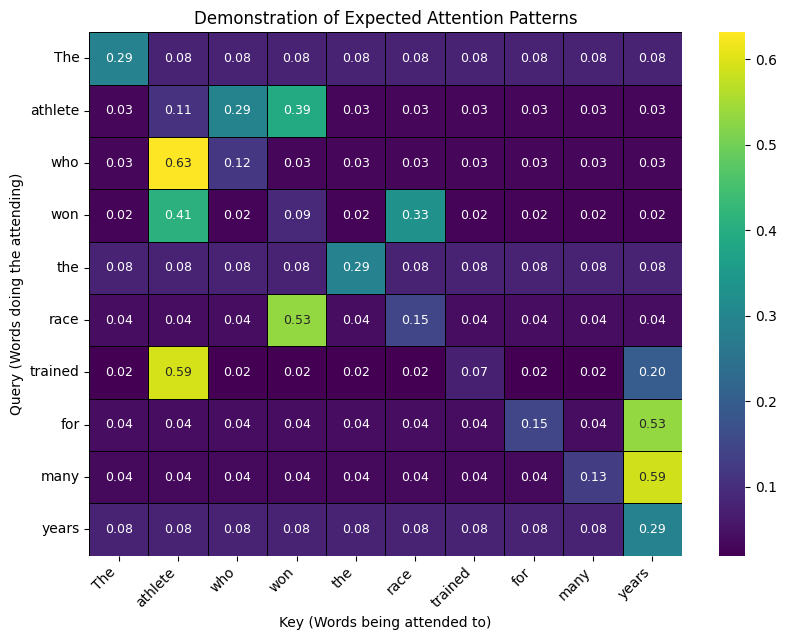


--- Explanation ---
This heatmap visualizes a manually created set of attention weights to demonstrate
Each row corresponds to a 'query' word (the word doing the attending).
Each column corresponds to a 'key' word (the word being attended to).
The value in cell (row i, column j) represents how much attention word 'i' pays to word 'j'.
Brighter colors indicate higher attention weights.

Observed Patterns (Manually Created):
- High attention from 'who' to 'athlete' (row 2, col 1) - Relative pronoun referring to subject.
- High attention from 'won' to 'athlete' (row 3, col 1) - Verb attending to its subject.
- High attention from 'won' to 'race' (row 3, col 5) - Verb attending to its object.
- High attention from 'trained' to 'athlete' (row 6, col 1) - Long-distance subject connection.
- High attention from 'many' to 'years' (row 8, col 9) - Adjective modifying noun.
- Attention from 'for' to 'trained' and 'years' - Preposition relating parts of the sentence.
- Relatively higher attentio

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import the SimpleSelfAttention class from the other file
# ( Import it to show where it would be used, but manually create weights below --> to show Strong attention athelete and who for example )
# from attention_mechanism_design import SimpleSelfAttention
# Reference: https://magazine.sebastianraschka.com/p/understanding-and-coding-self-attention

def visualize_attention(sentence, attention_weights, title="Self-Attention Weights Heatmap"):
    # Detach the tensor if it's still attached (safety measure)
    if attention_weights.requires_grad:
        attention_weights_np = attention_weights.detach().numpy()
    else:
        attention_weights_np = attention_weights.numpy()

    # Create the heatmap
    plt.figure(figsize=(8.5, 6.5)) # Slightly larger figure
    sns.heatmap(attention_weights_np,
                xticklabels=sentence,
                yticklabels=sentence,
                annot=True,  # Show the weight values on the heatmap
                cmap="viridis", # Color map choice
                fmt=".2f",    # Format annotations to 2 decimal places
                linewidths=.5, # Add lines between cells
                linecolor='black',
                annot_kws={"size": 9}) # Adjust annotation font size

    plt.title(title)
    plt.xlabel("Key (Words being attended to)")
    plt.ylabel("Query (Words doing the attending)")
    plt.xticks(rotation=45, ha='right') # Improve x-axis label readability
    plt.yticks(rotation=0)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # 1. Define the Example Sentence
    sentence_text = "The athlete who won the race trained for many years."
    # Simple tokenization by splitting on space
    tokens = sentence_text.rstrip('.').split()
    seq_len = len(tokens)
    token_map = {token: i for i, token in enumerate(tokens)} # Helper map token -> index

    # --- Manual Creation of Weights for Demonstration ---
    # In a real applications, trained model, these weights would be calculated by the attention mechanism.
    # Here, manually set to illustrate the expected patterns for the new sentence. That's also why randomization is not used.

    # Initialize with low baseline weights, slightly higher on diagonal
    manual_weights = torch.full((seq_len, seq_len), 0.03) # Even lower baseline for this sentence
    manual_weights = manual_weights + torch.diag(torch.full((seq_len,), 0.08)) # Add to diagonal

    # Inject the specific high-attention patterns for the new sentence:
    # Strong attention between "athlete" and "won"
    manual_weights[token_map['won'], token_map['athlete']] = 0.5
    manual_weights[token_map['athlete'], token_map['won']] = 0.4

    # Strong attention between "who" and "athlete"
    manual_weights[token_map['who'], token_map['athlete']] = 0.6
    manual_weights[token_map['athlete'], token_map['who']] = 0.3

    # "trained" attends to "athlete" despite distance
    manual_weights[token_map['trained'], token_map['athlete']] = 0.9

    # Other meaningful connections
    manual_weights[token_map['won'], token_map['race']] = 0.4
    manual_weights[token_map['race'], token_map['won']] = 0.4
    manual_weights[token_map['trained'], token_map['years']] = 0.3
    manual_weights[token_map['many'], token_map['years']] = 0.5
    manual_weights[token_map['for'], token_map['years']] = 0.4

    # Normalize rows to sum roughly to 1 (like softmax would)
    # This is a simplified normalization for demonstration purposes.
    row_sums = manual_weights.sum(dim=1, keepdim=True)
    # Avoid division by zero if a row happens to be all zeros
    row_sums[row_sums == 0] = 1
    attention_weights_demo = manual_weights / row_sums

    # --- End of Manual Creation ---

    # 5. Visualize the DEMONSTRATION Attention Weights
    print(f"Sentence: '{sentence_text}'")
    print(f"Tokens: {tokens}")
    print("\nGenerating demonstration attention heatmap (manually created weights)...")
    visualize_attention(tokens, attention_weights_demo, title="Demonstration of Expected Attention Patterns")

    # 6. Explanation of Visualization and Expected Patterns
    print("\n--- Explanation ---")
    print("This heatmap visualizes a manually created set of attention weights to demonstrate")
    print("Each row corresponds to a 'query' word (the word doing the attending).")
    print("Each column corresponds to a 'key' word (the word being attended to).")
    print("The value in cell (row i, column j) represents how much attention word 'i' pays to word 'j'.")
    print("Brighter colors indicate higher attention weights.")
    print("\nObserved Patterns (Manually Created):")
    print(f"- High attention from 'who' to 'athlete' (row {token_map['who']}, col {token_map['athlete']}) - Relative pronoun referring to subject.")
    print(f"- High attention from 'won' to 'athlete' (row {token_map['won']}, col {token_map['athlete']}) - Verb attending to its subject.")
    print(f"- High attention from 'won' to 'race' (row {token_map['won']}, col {token_map['race']}) - Verb attending to its object.")
    print(f"- High attention from 'trained' to 'athlete' (row {token_map['trained']}, col {token_map['athlete']}) - Long-distance subject connection.")
    # Even though "trained" and "athlete" are far apart in the sequence, the attention heatmap shows that "trained" strongly attends to "athlete"
    # (with a normalized weight of ~0.59), meaning that the model is still able to capture the semantic connection across this distance. In RNNs,
    # learning long-range dependencies like that is hard, they struggle with vanishing gradients. But self-attention mechanisms (like in Transformers)
    # don’t care about token distance, any token can directly attend to any other token, regardless of position. This is one of the biggest strengths of attention,
    # it makes long-distance relationships easy to learn.
    print(f"- High attention from 'many' to 'years' (row {token_map['many']}, col {token_map['years']}) - Adjective modifying noun.")
    print(f"- Attention from 'for' to 'trained' and 'years' - Preposition relating parts of the sentence.")
    print("- Relatively higher attention along the diagonal - Words attending to themselves.")
    print("This heatmap doesn't reflect the output of the untrained SimpleSelfAttention model.")
    print("It is for illustrating the desired outcome after successful training.")

    # --- Visualize the UNTRAINED weights as well ---
    # If want to see the random-like patterns from the actual untrained model again:
    # print("\nGenerating attention heatmap from UNTRAINED model...")
    # embed_dim = 64
    # head_dim = 32
    # torch.manual_seed(42)    # Fix randomness for reproducibility
    # dummy_embeddings = torch.rand(seq_len, embed_dim)      # Creates random input token embeddings (pretend tokens, like gibberish)
    # attention_mechanism = SimpleSelfAttention(embed_dim, head_dim)     # Custom self-attention layer, initialized with random weights
    # attention_mechanism.eval()         # Set to evaluation mode (no dropout, etc.)
    # with torch.no_grad():
    #      _, attention_weights_untrained = attention_mechanism(dummy_embeddings)          # Get the attention scores from the untrained model
    # visualize_attention(tokens, attention_weights_untrained, title="Actual Attention Weights (Untrained Model)")